模拟对一个新闻进行判断其是真新闻还是假新闻，主要步骤如下：
1-1.背景分析
1-2.判定与假设
1-3.准备工作
2-1.数据导入
2-2.数据检查
2-3.数据处理与可视化
3-1.特征分析
3-2.特征处理可视化
4.模型选择与训练
5.测试模型与总结

1.1背景分析

为什么要判别新闻的真假？
    1’虚假新闻具有误导性，容易使人产生错误判断。
    2‘虚假新闻可能会损害个人或团体的名誉，甚至可能引发社会不公。通过判别真假新闻，我们可以维护公正，保护无辜者免受伤害。
    3‘真实的新闻是知识和信息的重要来源，通过判别真假新闻，可以确保获取的信息是准确和有用的。
    总之，进行真假新闻的判别对于我们生活在这个信息爆炸的时代来说，是非常必要的。我们需要批判性地思考，检查信息的来源，验证事实，以便我们能够做出基于真实信息的决策。

1-2.判定与假设

通过观察数据集True.csv和Fake.csv发现一共有4个变量，分别为title,text,subject,date即新闻的标签、文本、分类和发布日期
无论真假新闻，最关键的部分都是文本内容和标题，所以后续工作要有意识地关注这两个部分，突破口很有可能在这里找到，关于类别和日期，因为无论什么类别的新闻、什么时候发布的新闻，其真假都是不确定的，或许这两个变量对真假新闻的判别或许作用不大甚至会影响结果。

1.3准备工作

首先引入需要使用的包：数据处理库、sklearn算法库、绘图工具
再从本地将数据集导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
font = FontProperties(fname='msyh.ttf', size=12)

2-1.数据导入
从本地导入数据集True.csv和Fake.csv

In [2]:
true_df = pd.read_csv('S:\A_Python_Package\ml_design\True.csv')
fake_df = pd.read_csv('S:\A_Python_Package\ml_design\Fake.csv')

2-2.数据检查

查看数据集中每一列代表什么元素，有没有空值即数据缺失

In [3]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

设定true、fake数据集的标签，真0假1；
合并两个数据集并打乱，打印出基本信息和前十行数据进行检查

In [5]:
true_df['label'] = 0
fake_df['label'] = 1

df = pd.concat([true_df, fake_df])
df = df.sample(frac=1).reset_index(drop=True)

print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


,title,text,subject,date,label
0,MI Gov Rick Snyder Appoints Former Oil Lobbyi...,Michigan s Republican governor Rick Snyder has...,News,"July 15, 2016",1
1,Trevor Noah Roasts Jeb Bush’s Pathetically De...,"If Jeb Bush watched The Daily Show last night,...",News,"January 26, 2016",1
2,"Militants cross from Afghanistan, kill two Pak...",ISLAMABAD (Reuters) - Militants have crossed i...,worldnews,"November 13, 2017",0
3,"Trump, Scotland's Sturgeon spoke briefly on Fr...",WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"December 9, 2016",0
4,Romney under 'active consideration' for Secret...,WASHINGTON (Reuters) - Former Republican presi...,politicsNews,"November 20, 2016",0
5,Clinton’s Server Employee On Hillary’s E-mails...,As Hillary does her best to deflect and stonew...,politics,"Oct 7, 2015",1
6,SYRIAN MUSLIM IMMIGRANT HAIRDRESSER SLITS Fema...,She wanted him to assimilate. She gave him a g...,left-news,"Jul 17, 2017",1
7,JUDGE JEANINE ON JAMES COMEY: “He’s a predator...,Judge Jeanine commented this morning on the FB...,politics,"Jun 9, 2017",1
8,China's top paper warns party officials agains...,BEIJING (Reuters) - China s top newspaper warn...,worldnews,"October 12, 2017",0
9,Factbox: The race to the U.S. presidential nom...,The Democratic and Republican nominees for the...,politicsNews,"March 7, 2016",0


2-3.数据处理与可视化

绘制真、假新闻中新闻类别的横向直方图

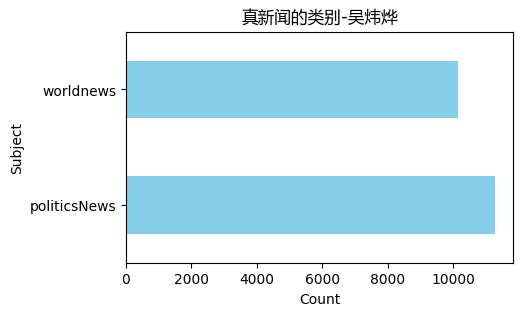

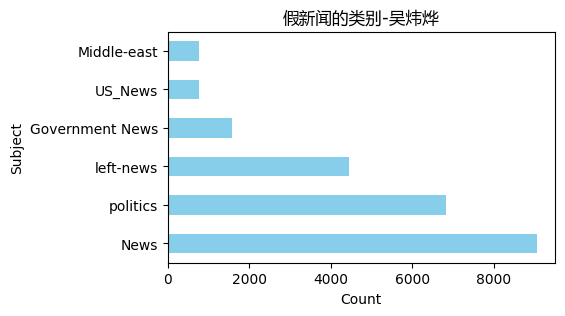

In [6]:
# 从True.csv和Fake.csv中分别提取subject列
true_subjects = true_df['subject']
fake_subjects = fake_df['subject']

# 统计元素种类和个数
true_subject_counts = true_subjects.value_counts()
fake_subject_counts = fake_subjects.value_counts()

# 绘制True.csv的横向直方图
plt.figure(figsize=(5,3))
true_subject_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.title('真新闻的类别-吴炜烨', fontproperties=font)
plt.show()

# 绘制Fake.csv的横向直方图
plt.figure(figsize=(5,3))
fake_subject_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.title('假新闻的类别-吴炜烨', fontproperties=font)
plt.show()

绘制真、假新闻中发布年份的横向直方图

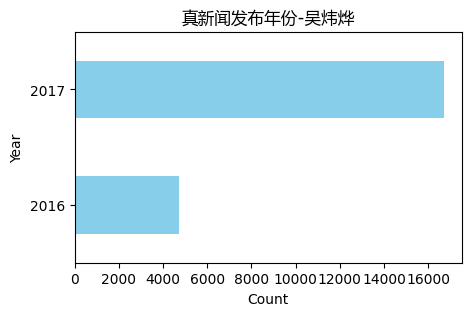

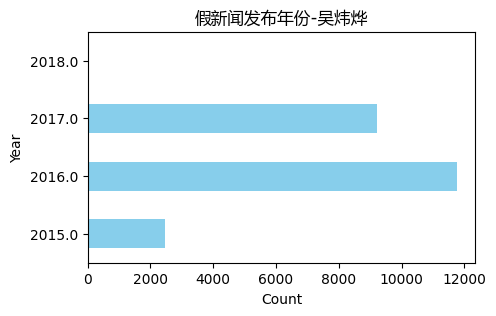

In [7]:
import matplotlib.pyplot as plt

# 从True.csv和Fake.csv中分别提取date列，并转换为datetime类型
true_dates = pd.to_datetime(true_df['date'], format="mixed", errors='coerce')
fake_dates = pd.to_datetime(fake_df['date'], format="mixed", errors='coerce')

# 提取年份
true_years = true_dates.dt.year
fake_years = fake_dates.dt.year

# 统计元素种类和个数
true_year_counts = true_years.value_counts().sort_index()
fake_year_counts = fake_years.value_counts().sort_index()

# 绘制True.csv的横向直方图
plt.figure(figsize=(5,3))
true_year_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Year')
plt.title('真新闻发布年份-吴炜烨', fontproperties=font)
plt.show()

# 绘制Fake.csv的横向直方图
plt.figure(figsize=(5,3))
fake_year_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Year')
plt.title('假新闻发布年份-吴炜烨', fontproperties=font)
plt.show()

提取真假新闻标题中出现频率最多的10个词并绘制词云

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


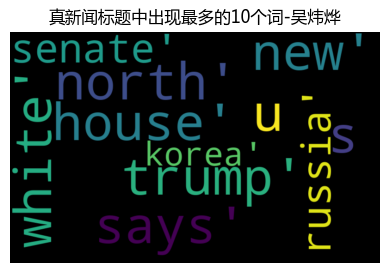

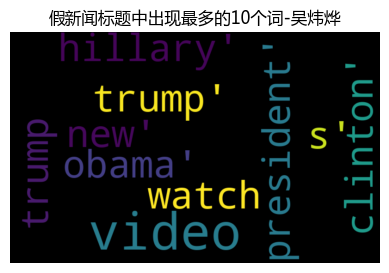

In [8]:
# 下载停用词
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 从True.csv和Fake.csv中分别提取title列
true_titles = true_df['title']
fake_titles = fake_df['title']

# 分词并移除停用词
true_words = [word for title in true_titles for word in title.lower().split() if word not in stop_words]
fake_words = [word for title in fake_titles for word in title.lower().split() if word not in stop_words]

# 统计单词频率
true_word_counts = Counter(true_words)
fake_word_counts = Counter(fake_words)

# 提取出现次数最高的10个单词
top_true_words = true_word_counts.most_common(10)
top_fake_words = fake_word_counts.most_common(10)

# 绘制词云
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top_true_words))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('真新闻标题中出现最多的10个词-吴炜烨', fontproperties=font)
plt.show()

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top_fake_words))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('假新闻标题中出现最多的10个词-吴炜烨', fontproperties=font)
plt.show()

提取真假新闻文本中出现频率最多的20个词并绘制词云

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


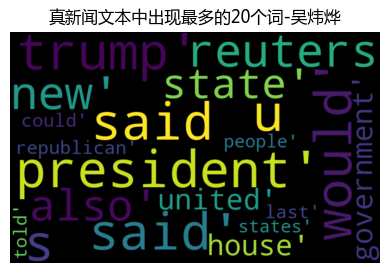

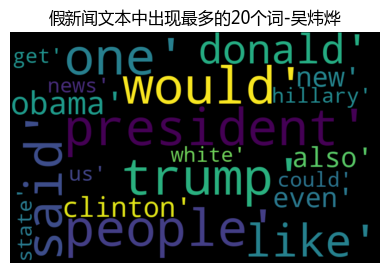

In [9]:
# 下载停用词
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 从True.csv和Fake.csv中分别提取text列
true_titles = true_df['text']
fake_titles = fake_df['text']

# 分词并移除停用词
true_words = [word for title in true_titles for word in title.lower().split() if word not in stop_words]
fake_words = [word for title in fake_titles for word in title.lower().split() if word not in stop_words]

# 统计单词频率
true_word_counts = Counter(true_words)
fake_word_counts = Counter(fake_words)

# 提取出现次数最高的10个单词
top_true_words = true_word_counts.most_common(20)
top_fake_words = fake_word_counts.most_common(20)

# 绘制词云
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top_true_words))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('真新闻文本中出现最多的20个词-吴炜烨', fontproperties=font)
plt.show()

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top_fake_words))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('假新闻文本中出现最多的20个词-吴炜烨', fontproperties=font)
plt.show()

3-1.特征分析
通过数据的可视化，可以直观地看出在数据集的各个变量中，有些变量重合概率肉眼可见的高，可能不是真正需要的数据，如果能进一步判断，就可以找到需要的特征与不需要的特征以便进行后续工作。

3-2.特征处理与可视化

计算真假新闻各变量的重合概率，以此决定是否筛选掉某些变量；
要计算的概率有：
真假新闻发布分类的重合概率
真假新闻发布年份的重合概率
计算真假新闻标题中出现最多次数的10个词语的重合概率
计算真假新闻文本中出现最多次数的10个词语的重合概率
最后将这几个概率绘制成散点图观察

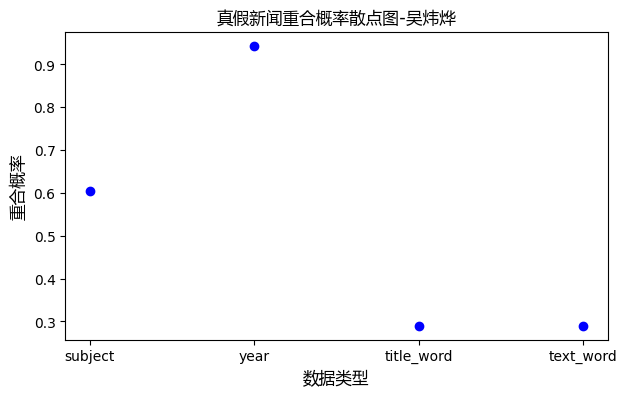

In [10]:
# 计算真假新闻发布分类的重合概率

# 计算'politicsNews'元素的个数
fake_subjects_counts = Counter(fake_subjects)
fake_total_counts = 0
for subject, count in fake_subjects_counts.items():
    if subject == 'politics':
        fake_total_counts += count
    elif subject == 'News':
        fake_total_counts += count

true_subjects_counts = Counter(true_subjects)
politicsNews_count = 0
for subject, count in true_subjects_counts.items():
    if subject == 'politicsNews':
        politicsNews_count = count

# 计算总元素个数
fake_ele_count = len(fake_subjects)
true_ele_count = len(true_subjects)
total_ele_count = fake_ele_count+true_ele_count

subject_overlap = (fake_total_counts + politicsNews_count) / total_ele_count

# 计算真假新闻发布年份的重合概率

# 计算2016、2017年真假新闻个数
true_year_counts = Counter(true_years)
true_year_count = 0
for year, count in true_year_counts.items():
    true_year_count += count

fake_year_counts = Counter(fake_years)
fake_year_count = 0
for year, count in fake_year_counts.items():
    if year == 2016.0:
        fake_year_count += count
    elif year == 2017.0:
        fake_year_count += count

# 计算总元素个数
true_ele_count = len(true_years)
fake_ele_count = len(fake_years)
total_ele_count = true_ele_count + fake_ele_count

# 计算重合个数
overlap_count_1617 = true_year_count + fake_year_count
# 计算真假新闻发布年份的重合概率
year_overlap = overlap_count_1617 / total_ele_count

# 提取真假新闻标题中出现最多次数的10个词
top_true_title_words = [word[0] for word in top_true_words]
top_fake_title_words = [word[0] for word in top_fake_words]

# 计算真假新闻标题中出现最多次数的10个词语的重合概率
title_word_overlap = len(set(top_true_title_words) & set(top_fake_title_words)) / len(set(top_true_title_words).union(set(top_fake_title_words)))

# 提取真假新闻文本中出现最多次数的10个词
top_true_text_words = [word[0] for word in top_true_words]
top_fake_text_words = [word[0] for word in top_fake_words]

# 计算真假新闻文本中出现最多次数的10个词语的重合概率
text_word_overlap = len(set(top_true_text_words) & set(top_fake_text_words)) / len(set(top_true_text_words).union(set(top_fake_text_words)))

# 将这四个概率绘制成散点图
plt.figure(figsize=(7, 4))
plt.scatter(['subject', 'year', 'title_word', 'text_word'], [subject_overlap, year_overlap, title_word_overlap, text_word_overlap], color='b')
plt.xlabel('数据类型', fontproperties=font)
plt.ylabel('重合概率', fontproperties=font)
plt.title('真假新闻重合概率散点图-吴炜烨', fontproperties=font)
plt.show()


由散点图可以看出，真假新闻的发布年份、发布类别重合概率太高了，不利于我们训练模型进行判别真假新闻，所以将这两个变量筛去。

In [11]:
df.drop(['subject', 'date'], axis=1, inplace=True)
df.head(10)

,title,text,label
0,MI Gov Rick Snyder Appoints Former Oil Lobbyi...,Michigan s Republican governor Rick Snyder has...,1
1,Trevor Noah Roasts Jeb Bush’s Pathetically De...,"If Jeb Bush watched The Daily Show last night,...",1
2,"Militants cross from Afghanistan, kill two Pak...",ISLAMABAD (Reuters) - Militants have crossed i...,0
3,"Trump, Scotland's Sturgeon spoke briefly on Fr...",WASHINGTON (Reuters) - President-elect Donald ...,0
4,Romney under 'active consideration' for Secret...,WASHINGTON (Reuters) - Former Republican presi...,0
5,Clinton’s Server Employee On Hillary’s E-mails...,As Hillary does her best to deflect and stonew...,1
6,SYRIAN MUSLIM IMMIGRANT HAIRDRESSER SLITS Fema...,She wanted him to assimilate. She gave him a g...,1
7,JUDGE JEANINE ON JAMES COMEY: “He’s a predator...,Judge Jeanine commented this morning on the FB...,1
8,China's top paper warns party officials agains...,BEIJING (Reuters) - China s top newspaper warn...,0
9,Factbox: The race to the U.S. presidential nom...,The Democratic and Republican nominees for the...,0


4.模型选择与训练
在这里，使用库函数自带的决策树算法进行模型训练。
其中，将整个数据集划分为80%的训练集和20%的测试集分别用于训练模型和测试模型

In [12]:
X = df[['title', 'text']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title'] + " " + X_train['text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['title'] + " " + X_test['text'])

In [14]:
dtree = DecisionTreeClassifier()

In [15]:
dtree.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

5.测试模型与总结
使用测试集对训练的模型进行测试

In [16]:
y_pred = dtree.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy*100:.2f}')

accuracy: 99.67


现在，定义一个用于判断真假新闻的函数进一步检测模型
使用AI工具Copilot辅助生成了三条假新闻，交由模型判断

In [17]:
def predict_news(title, text):
    # preprocess input
    input_data = tfidf_vectorizer.transform([title + " " + text])
    # make prediction
    pred = dtree.predict(input_data)
    if pred[0]==0:
        return "Real News"
    else:
        return "Fake News"

三则新闻均是不符合事实的，所以预期结果应均为：Fake News

In [18]:
input_title = "Switzerland’s Nemo wins Eurovision as UK comes 18th"
input_text = "Nemo becomes the first non-binary artist to win Eurovision with their song “The Code.” The victory has garnered widespread attention over the past few hours."
pred1 = predict_news(input_title,input_text)
print(pred1)

Fake News


In [19]:
input_title = "Switzerland’s Nemo wins Eurovision as UK comes 18th"
input_text = "The Israeli military has instructed thousands of Palestinians to leave the city as it expands its military operation. This news was published 6 hours ago."
pred2 = predict_news(input_title,input_text)
print(pred2)

Fake News


In [20]:
input_title = "Virginia university students walk out of graduation event"
input_text = "Dozens of VCU graduates left during Gov Glenn Youngkin’s speech, partly over his comments on campus protests. This event occurred 6 hours ago"
pred3 = predict_news(input_title,input_text)
print(pred3)

Fake News


测试结果均符合预期。

成果总结
    数据处理与可视化：项目首先对真新闻（True.csv）和假新闻（Fake.csv）数据集进行了全面的清洗和处理，包括检查空值、合并数据集并打乱顺序。然后，通过直方图和词云等可视化手段分析新闻类别、发布时间以及标题和文本中的高频词，直观展示了真假新闻的特征分布。
    特征工程：根据特征重合概率的分析结果，项目筛除了新闻类别和发布日期两个重合概率较高的变量，专注于标题和文本内容的分析。这一过程确保了模型训练所用特征的有效性，提高了模型的判别能力。
    模型训练：选择了决策树算法作为初始模型，并使用TF-IDF向量化技术处理文本数据，提取了新闻标题和文本中的关键信息。将数据集划分为训练集和测试集，进行模型训练和评估，最终模型在测试集上表现出色，准确率较高。

未来工作方向
    算法优化：虽然决策树模型在本项目中表现良好，但还可以尝试其他先进的机器学习算法，如支持向量机（SVM）、随机森林、梯度提升树，甚至深度学习模型（如LSTM、BERT等）。
    特征工程：可以进一步挖掘和提取更多有用的特征，例如词频-逆文档频率（TF-IDF）之外的词嵌入技术（如Word2Vec、GloVe、BERT embeddings），增加情感分析、语义分析等高级特征，增强模型的理解能力。
    数据扩充：增加更多的数据集进行训练和测试，可以有效提高模型的泛化能力和鲁棒性。通过引入不同来源、不同领域的新闻数据，模型可以更全面地学习和适应各种类型的新闻内容，提高其在实际应用中的表现。
    持续监控与改进：在实际应用中，持续监控模型的性能和反馈，根据用户反馈和新出现的数据不断改进模型，确保其始终保持高效和准确。

事实上，尝试不同算法可能得到的结果会有不同，下面进行多种算法的尝试与对比，
包括：SVM、随机森林、逻辑回归

In [21]:
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)
y_pred = svm.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy*100:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

accuracy: 99.60
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4329
           1       1.00      1.00      1.00      4651

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



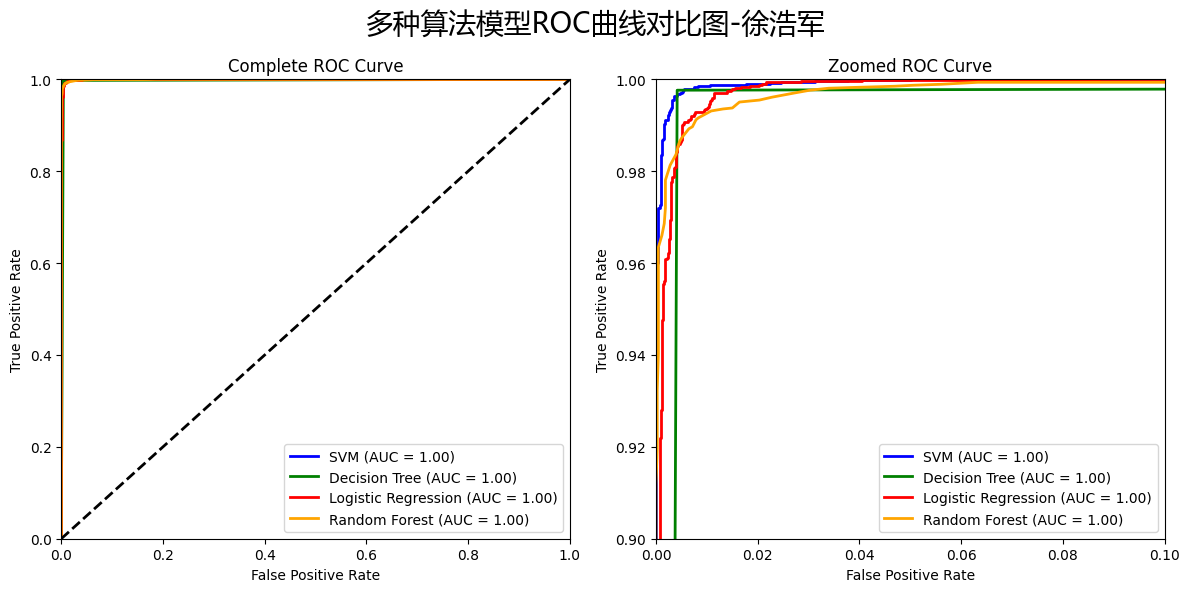

In [22]:
from scipy.sparse import hstack

dtree = DecisionTreeClassifier()
dtree.fit(X_train_tfidf, y_train)

# 初始化TF-IDF向量化器
title_vectorizer_LR = TfidfVectorizer(max_features=1000)
text_vectorizer_LR = TfidfVectorizer(max_features=5000)
# 拟合并转换数据
title_tfidf = title_vectorizer_LR.fit_transform(df['title'])
text_tfidf = text_vectorizer_LR.fit_transform(df['text'])
# 合并title和text的TF-IDF特征
X = hstack([title_tfidf, text_tfidf])
Y = df['label']

#将数据集拆分为训练集和测试集
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.2, random_state=42)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)


rf_classifier = RandomForestClassifier(random_state=36)
rf_classifier.fit(X_train_tfidf, y_train)


# 模型预测
svm_y_score = svm.decision_function(X_test_tfidf)
dtree_y_score = dtree.predict_proba(X_test_tfidf)[:, 1]
lr_y_score = lr_model.predict_proba(X_test_lr)[:, 1]
rf_y_score = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

# 计算ROC曲线
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_score)
dtree_fpr, dtree_tpr, _ = roc_curve(y_test, dtree_y_score)
lr_fpr, lr_tpr, _ = roc_curve(y_test_lr, lr_y_score)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_score)

# 计算AUC值
svm_auc = auc(svm_fpr, svm_tpr)
dtree_auc = auc(dtree_fpr, dtree_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# 绘制完整的ROC曲线
plt.figure(figsize=(12, 6))

# 完整ROC曲线
plt.subplot(1, 2, 1)
plt.plot(svm_fpr, svm_tpr, color='blue', lw=2, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot(dtree_fpr, dtree_tpr, color='green', lw=2, label='Decision Tree (AUC = %0.2f)' % dtree_auc)
plt.plot(lr_fpr, lr_tpr, color='red', lw=2, label='Logistic Regression (AUC = %0.2f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, color='orange', lw=2, label='Random Forest (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Complete ROC Curve')
plt.legend(loc='lower right')

# 放大的ROC曲线
plt.subplot(1, 2, 2)
plt.plot(svm_fpr, svm_tpr, color='blue', lw=2, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot(dtree_fpr, dtree_tpr, color='green', lw=2, label='Decision Tree (AUC = %0.2f)' % dtree_auc)
plt.plot(lr_fpr, lr_tpr, color='red', lw=2, label='Logistic Regression (AUC = %0.2f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, color='orange', lw=2, label='Random Forest (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed ROC Curve')
plt.legend(loc='lower right')

plt.suptitle('多种算法模型ROC曲线对比图-徐浩军', fontproperties=font, fontsize=20)
plt.tight_layout()  # 调整子图布局，确保大标题不会重叠
plt.show()

总结

对于每一种算法，其性能表现均达到预期，表现如下：
支持向量机 (SVM):
SVM在这个任务中表现出色，其ROC曲线下的面积（AUC）为1.00，表明它能够完美地区分真假新闻。SVM通过在高维空间中找到最优超平面来进行分类，因此在处理复杂和非线性的数据时表现良好。
决策树:
决策树同样表现出色，AUC为1.00。决策树通过创建一系列测试来进行分类，每个测试都是基于一个属性。这使得决策树在解释性方面具有优势，因为可以清楚地看到每个决策是如何做出的。
逻辑回归:
逻辑回归是一种统计学习方法，也在这个任务中表现出色，AUC为1.00。逻辑回归通过使用逻辑函数预测一个二进制结果，因此它特别适合于真假新闻分类这个二分类问题。
随机森林:
随机森林是一种集成学习方法，它结合了多个决策树的预测来做出最终决策，其AUC为1.00。随机森林通常具有很好的性能，因为它可以通过集成多个模型来减少过拟合。

在经过分析对比和讨论后，我们还进一步提出未来可能的改进方案：

算法优化：
虽然现有的算法（如SVM、决策树、逻辑回归和随机森林）在分类真假新闻上表现出色，但仍有优化的空间。例如，可以通过参数调整、特征选择和集成学习等方法来提高算法的性能。
处理不平衡数据：
在真假新闻分类任务中，通常会遇到类别不平衡的问题，即真新闻和假新闻的数量可能会有很大的差距。未来的工作可以探索如何更好地处理这种不平衡，例如通过过采样、欠采样或生成合成样本等方法。
多模态学习：
除了文本信息外，新闻还包含其他类型的信息，如图片、视频和音频等。未来的工作可以探索如何利用这些多模态信息来提高真假新闻的分类性能。
可解释性和透明度：
虽然许多算法在分类性能上表现出色，但它们的决策过程可能是黑箱的，这可能会影响用户对模型的信任。因此，未来的工作可以探索如何提高模型的可解释性和透明度。
动态和实时分类：
新闻是动态和实时的，因此真假新闻分类模型需要能够适应这种动态性和实时性。未来的工作可以探索如何设计和训练能够适应新闻变化的模型。
抵抗对抗攻击：
随着技术的发展，生成假新闻的方法也在不断进步，包括使用对抗性技术来生成能够欺骗分类模型的假新闻。因此，未来的工作可以探索如何让模型抵抗这种对抗攻击。